<a href="https://colab.research.google.com/github/prithviemmidi/LifeSatisfactionAnalysis/blob/main/Decision_Tree_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [426]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.tree import plot_tree
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [427]:
path = "/content/drive/MyDrive/lifesat_csv.csv"
df_old = pd.read_csv(path)
df_old.head()

,pidp,agenew,incomecpi,male,neduc,ueduc,oheduc,Alevel,gcse,otheduc,...,member34,othersize,pomst,agesq,openness_std,neuroticism_std,agreeableness_std,extraversion_std,conscientiousness_std,yearid
0,68035365,45,1981.589,1,0,0,0,0,0,1,...,0,0,0.00000,2025,1.134772,1.7147,1.33485,0.318156,-0.471428,1
1,68035365,46,2110.081,1,0,0,0,0,0,1,...,0,0,33.33333,2116,1.134772,1.7147,1.33485,0.318156,-0.471428,2
2,68035365,46,2351.826,1,0,0,0,0,0,1,...,0,0,66.66666,2116,1.134772,1.7147,1.33485,0.318156,-0.471428,3
3,68035365,48,2219.140,1,0,0,0,0,0,1,...,0,0,66.66666,2304,1.134772,1.7147,1.33485,0.318156,-0.471428,4
4,68035365,49,2498.854,1,0,0,0,0,0,1,...,0,0,50.00000,2401,1.134772,1.7147,1.33485,0.318156,-0.471428,5


In [428]:
agg_rules = {col: 'mean' for col in df_old.columns if col != 'pidp'}
agg_rules['male'] = 'max'

df = df_old.groupby('pidp').agg(agg_rules).reset_index()

print(f"Original rows in df_old: {len(df_old)}")
print(f"Unique individuals in df: {len(df)}")

Original rows in df_old: 25128
Unique individuals in df: 1047


In [429]:
df.head()

,pidp,agenew,incomecpi,male,neduc,ueduc,oheduc,Alevel,gcse,otheduc,...,member34,othersize,pomst,agesq,openness_std,neuroticism_std,agreeableness_std,extraversion_std,conscientiousness_std,yearid
0,68035365,57.041667,2493.496375,1,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,40.972220,3308.041667,1.134772,1.714700,1.334850,0.318156,-0.471428,12.5
1,68058485,64.291667,4008.875375,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.125000,0.083333,58.333329,4185.458333,-0.410277,1.714700,-0.626826,-0.449034,-0.471428,12.5
2,68058489,64.291667,4008.875375,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.125000,0.083333,78.472226,4185.458333,-1.955325,0.315594,-0.626826,-0.449034,-0.471428,12.5
3,68064609,57.291667,4231.804125,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.166667,0.125000,61.111114,3334.375000,0.362247,-0.383959,1.334850,1.085346,1.368915,12.5
4,68097245,58.791667,1964.208062,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,65.972222,3514.958333,1.134772,1.015147,0.354012,1.852535,-0.471428,12.5


In [430]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1047 entries, 0 to 1046
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pidp                   1047 non-null   int64  
 1   agenew                 1047 non-null   float64
 2   incomecpi              1047 non-null   float64
 3   male                   1047 non-null   int64  
 4   neduc                  1047 non-null   float64
 5   ueduc                  1047 non-null   float64
 6   oheduc                 1047 non-null   float64
 7   Alevel                 1047 non-null   float64
 8   gcse                   1047 non-null   float64
 9   otheduc                1047 non-null   float64
 10  single                 1047 non-null   float64
 11  married                1047 non-null   float64
 12  others                 1047 non-null   float64
 13  selfemploy             1047 non-null   float64
 14  employed               1047 non-null   float64
 15  unem

In [431]:
df.describe()

,pidp,agenew,incomecpi,male,neduc,ueduc,oheduc,Alevel,gcse,otheduc,...,member34,othersize,pomst,agesq,openness_std,neuroticism_std,agreeableness_std,extraversion_std,conscientiousness_std,yearid
count,1.047000e+03,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,...,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.0
mean,4.254653e+08,52.281797,4085.248531,0.436485,0.086796,0.218322,0.113976,0.205548,0.276226,0.099132,...,0.393545,0.059296,70.675476,2915.440823,-0.007413,-0.018481,-0.050689,-0.013047,0.048860,12.5
std,2.434545e+08,11.194397,2062.525185,0.496186,0.267597,0.403630,0.309850,0.390301,0.434353,0.286761,...,0.343424,0.158099,12.384463,1189.712462,0.947431,0.970993,0.968454,0.993709,0.919850,0.0
min,6.803536e+07,29.833333,696.105387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,15.277780,947.500000,-2.727849,-1.783065,-4.550178,-2.750603,-3.231943,12.5
25%,2.053444e+08,43.791667,2680.394821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.041667,0.000000,63.888889,1976.208333,-0.410277,-1.083512,-0.626826,-0.449034,-0.471428,12.5
50%,4.097122e+08,51.791667,3806.917375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.333333,0.000000,72.916665,2740.875000,0.362247,-0.383959,0.354012,0.318156,0.448744,12.5
75%,6.154190e+08,60.791667,4980.267125,1.000000,0.000000,0.000000,0.000000,0.000000,0.916667,0.000000,...,0.708333,0.000000,79.166670,3754.125000,0.362247,0.315594,0.354012,0.318156,0.448744,12.5
max,8.200304e+08,83.875000,18702.897917,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,97.916668,7095.041667,1.907296,2.414253,1.334850,1.852535,1.368915,12.5




```
Sorting into categorical variables
```



In [432]:
df["genders"] = df["male"].map({0: "Female", 1: "Male"})
df['marital_status'] = df[['single','married','others']].idxmax(axis=1)
df['employment_status'] = df[['selfemploy','employed','unemploy','retired','sick','familycare','student']].idxmax(axis=1)
df['household_size'] = df[['onemember','twomember','member34','othersize']].idxmax(axis=1)

In [433]:
df['education'] = df[['neduc','ueduc','oheduc','Alevel','gcse','otheduc']].idxmax(axis=1)
education_labels = {
    'neduc': 'None',
    'gcse': 'GCSE',
    'Alevel': 'A-level',
    'otheduc': 'Other ',
    'ueduc': 'University',
    'oheduc': 'Other Higher'}
df['education'] = df['education'].map(education_labels)

In [434]:
traits = [
    'openness_std',
    'neuroticism_std',
    'agreeableness_std',
    'extraversion_std',
    'conscientiousness_std']

In [435]:
df['pomst'].describe()

,pomst
count,1047.000000
mean,70.675476
std,12.384463
min,15.277780
25%,63.888889
50%,72.916665
75%,79.166670
max,97.916668


In [436]:
pomst_table = df['pomst'].value_counts()
pomst_table

,count
pomst,
79.166670,11
81.250005,9
80.555560,9
78.472225,8
81.250004,8
...,...
83.333338,1
70.833336,1
73.611113,1


Coding decision tree

In [437]:
features = traits + ['male']
target = 'pomst'

In [438]:
df_tree = df[features + [target]].dropna()

In [439]:
df_tree.head()

,openness_std,neuroticism_std,agreeableness_std,extraversion_std,conscientiousness_std,male,pomst
0,1.134772,1.714700,1.334850,0.318156,-0.471428,1,40.972220
1,-0.410277,1.714700,-0.626826,-0.449034,-0.471428,1,58.333329
2,-1.955325,0.315594,-0.626826,-0.449034,-0.471428,0,78.472226
3,0.362247,-0.383959,1.334850,1.085346,1.368915,0,61.111114
4,1.134772,1.015147,0.354012,1.852535,-0.471428,0,65.972222


decision tree

In [440]:
# Prepare X and y
X = df_tree[features]
y = df_tree[target]

Step 1: Growing Tree

In [441]:
tree_model = dtr(min_samples_leaf=75, criterion='squared_error', splitter='best',random_state=17)
tree_model.fit(X, y)

DecisionTreeRegressor(min_samples_leaf=75, random_state=17)

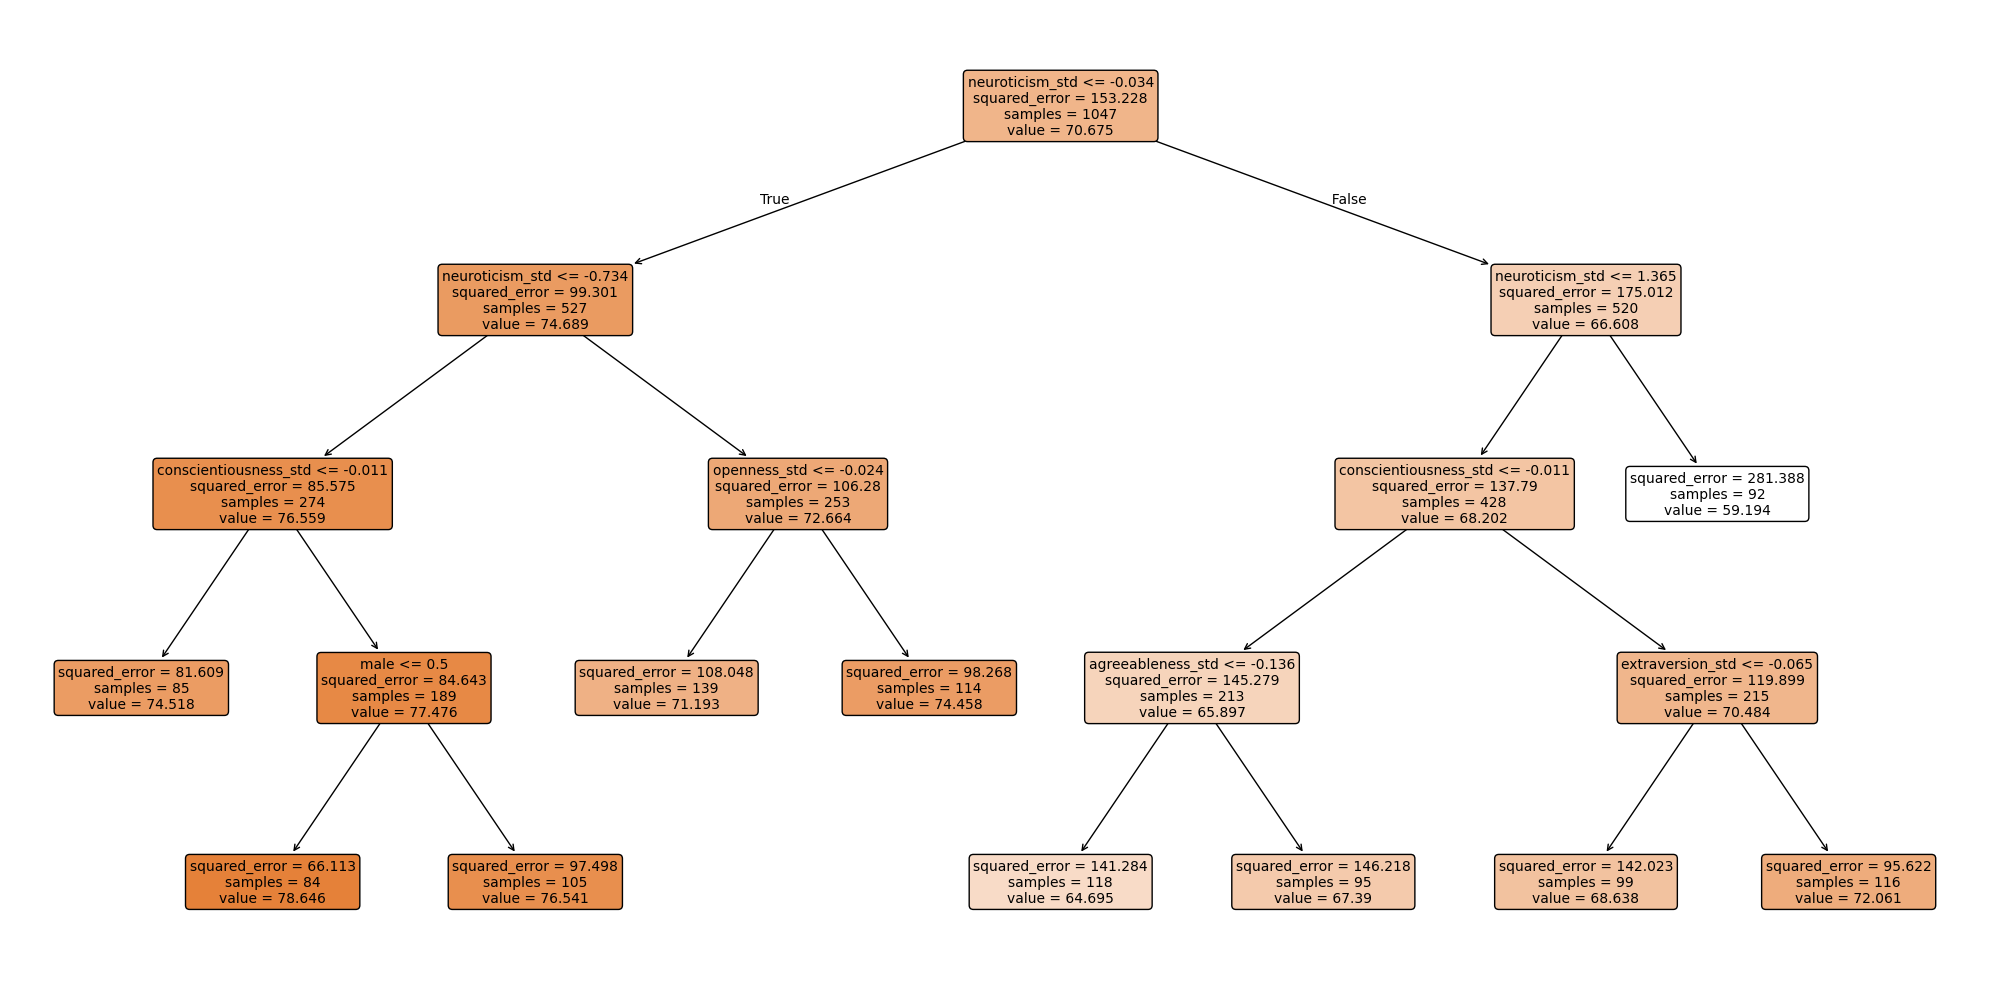

In [442]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model,
          feature_names=features,
          filled=True,
          rounded=True,
          fontsize=10)
plt.tight_layout()

In [443]:
# Print feature importance
print("Feature Importance:")
for feat, imp in zip(features, tree_model.feature_importances_):
    print(f"  {feat}: {imp:.3f}")

Feature Importance:
  openness_std: 0.022
  neuroticism_std: 0.844
  agreeableness_std: 0.013
  extraversion_std: 0.021
  conscientiousness_std: 0.093
  male: 0.007


Step 2: Cost complexity Pruning

In [444]:
path = tree_model.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [445]:
print(f"# of alpha values to test: {len(ccp_alphas)}")
print(f"Alpha range: {ccp_alphas.min():.6f} to {ccp_alphas.max():.6f}")

# of alpha values to test: 10
Alpha range: 0.000000 to 16.325358


Text(0.5, 1.0, 'Total Impurity vs effective alpha')

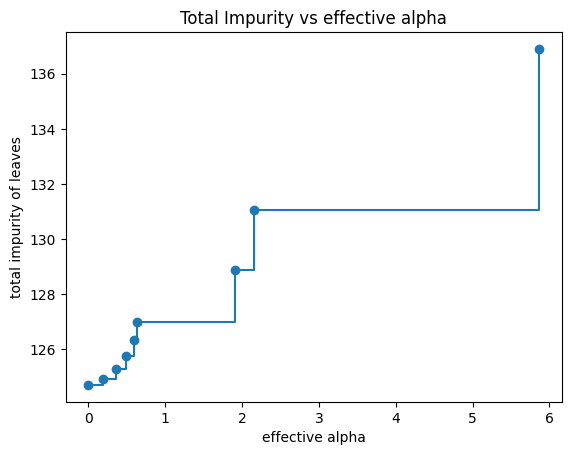

In [446]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha")

Assigning each terminal node to a dummy variable

In [447]:
leaf_indices = tree_model.apply(X)

In [448]:
print(f"Number of observations: {len(leaf_indices)}")
print(f"Unique leaf nodes: {np.unique(leaf_indices)}")
print(f"Number of leaves: {tree_model.get_n_leaves()}")

Number of observations: 1047
Unique leaf nodes: [ 3  5  6  8  9 13 14 16 17 18]
Number of leaves: 10


In [449]:
df['leaf_node'] = leaf_indices

In [450]:
# Dummy variables for each leaf
leaf_dummies = pd.get_dummies(df['leaf_node'], prefix='leaf')
df = pd.concat([df, leaf_dummies], axis=1)

In [451]:
df.head()

,pidp,agenew,incomecpi,male,neduc,ueduc,oheduc,Alevel,gcse,otheduc,...,leaf_3,leaf_5,leaf_6,leaf_8,leaf_9,leaf_13,leaf_14,leaf_16,leaf_17,leaf_18
0,68035365,57.041667,2493.496375,1,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,True
1,68058485,64.291667,4008.875375,1,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,68058489,64.291667,4008.875375,0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,True,False,False,False,False
3,68064609,57.291667,4231.804125,0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,True,False,False,False,False,False
4,68097245,58.791667,1964.208062,0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,True,False,False,False


running regression within each subtree

In [452]:
for i, leaf in enumerate(df['leaf_node'].unique(), start=1):
  subgroup = df[df['leaf_node'] == leaf]
  y_leaf = subgroup['pomst']
  X_leaf = sm.add_constant(subgroup['incomecpi'])
  model = sm.OLS(y_leaf, X_leaf).fit()

  print(f"\nSubtree {i} (leaf {leaf})")
  print(model.summary())


Subtree 1 (leaf 18)
                            OLS Regression Results                            
Dep. Variable:                  pomst   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     20.58
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           1.76e-05
Time:                        18:27:46   Log-Likelihood:                -380.50
No. Observations:                  92   AIC:                             765.0
Df Residuals:                      90   BIC:                             770.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.3300      3.64

including education to classify individuals

In [455]:
features2 = features + ['neduc','ueduc','oheduc','Alevel','gcse','otheduc']

In [456]:
df_tree2 = df[features2 + [target]].dropna()

In [457]:
df_tree2.head()

,openness_std,neuroticism_std,agreeableness_std,extraversion_std,conscientiousness_std,male,neduc,ueduc,oheduc,Alevel,gcse,otheduc,pomst
0,1.134772,1.714700,1.334850,0.318156,-0.471428,1,0.0,0.0,0.0,0.0,0.0,1.0,40.972220
1,-0.410277,1.714700,-0.626826,-0.449034,-0.471428,1,0.0,0.0,0.0,0.0,1.0,0.0,58.333329
2,-1.955325,0.315594,-0.626826,-0.449034,-0.471428,0,0.0,0.0,0.0,0.0,0.0,1.0,78.472226
3,0.362247,-0.383959,1.334850,1.085346,1.368915,0,0.0,0.0,0.0,0.0,1.0,0.0,61.111114
4,1.134772,1.015147,0.354012,1.852535,-0.471428,0,0.0,0.0,0.0,0.0,1.0,0.0,65.972222


In [458]:
# Prepare X and y
X2 = df_tree2[features2]
y2 = df_tree2[target]

In [459]:
tree_model2 = dtr(min_samples_leaf=75, criterion='squared_error', splitter='best',random_state=17)
tree_model2.fit(X2, y2)

DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=75,
                      random_state=17)

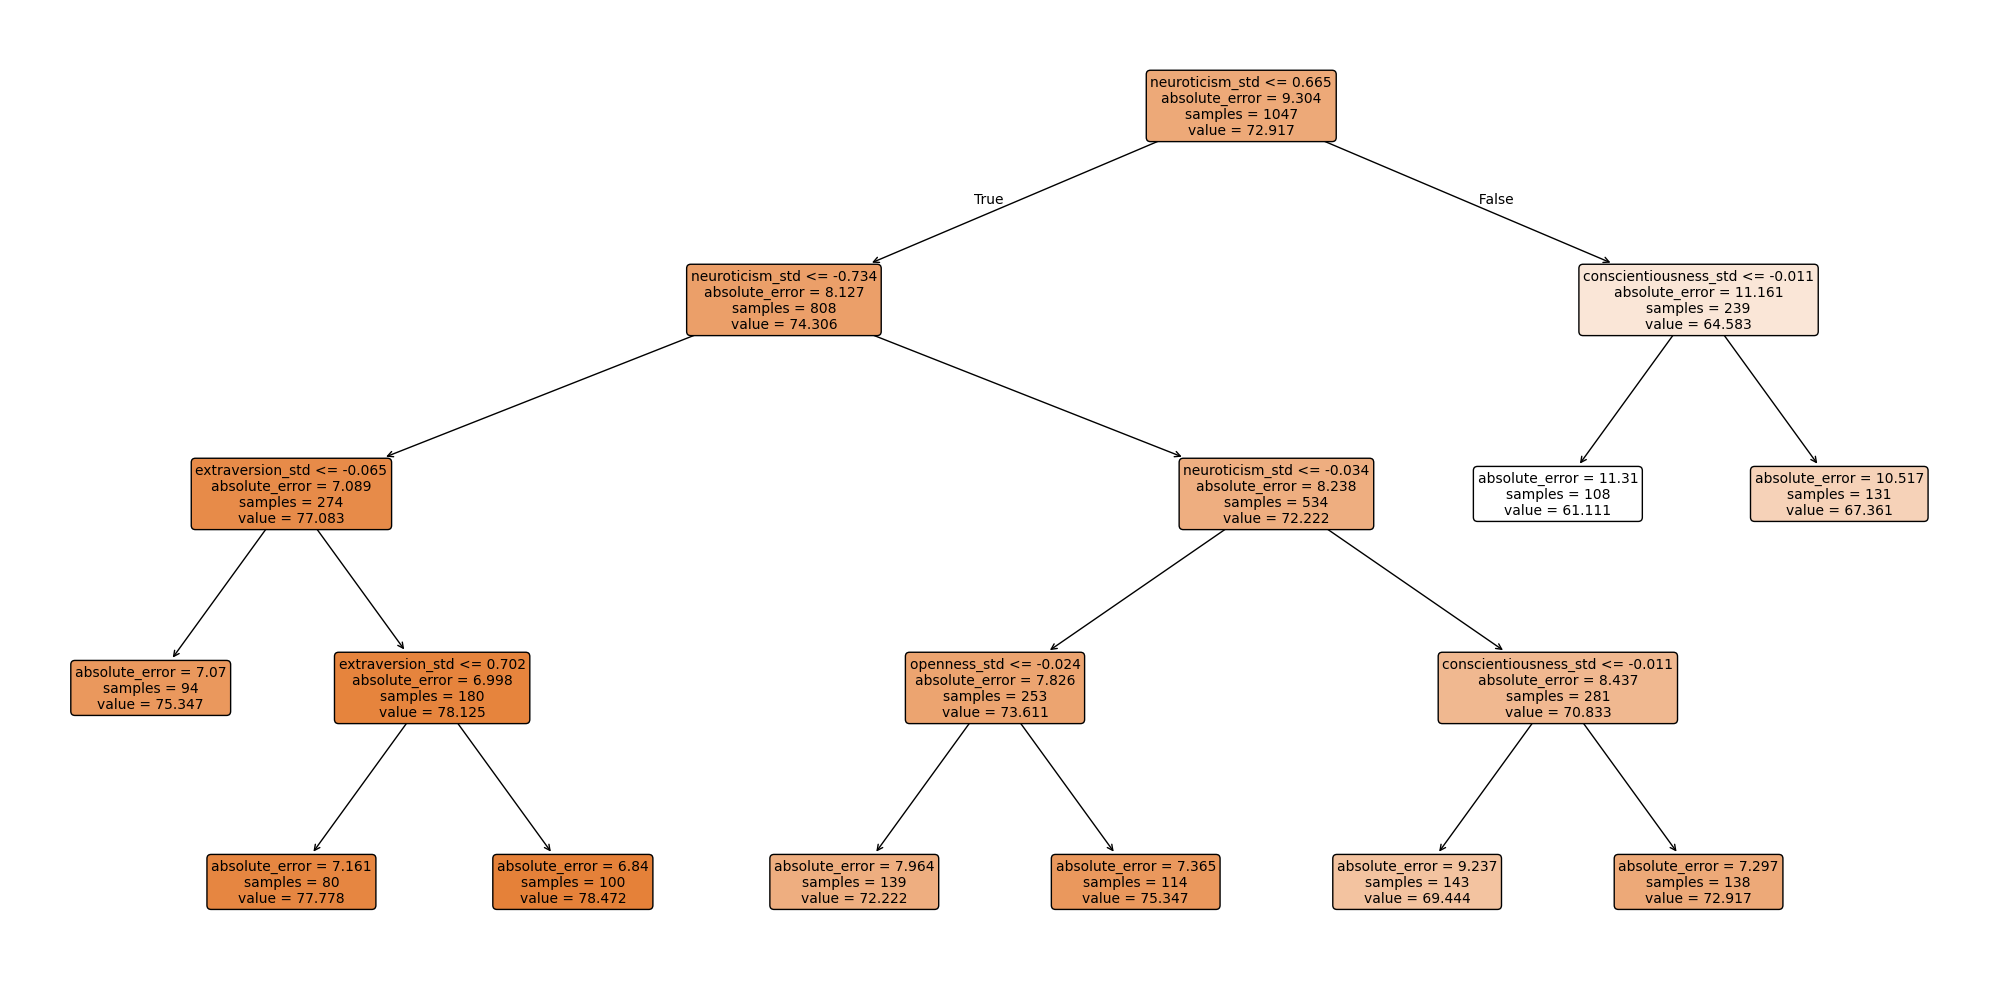

In [460]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model2,
          feature_names=features2,
          filled=True,
          rounded=True,
          fontsize=10)
plt.tight_layout()

In [461]:
# Print feature importance
print("Feature Importance:")
for feat, imp in zip(features2, tree_model2.feature_importances_):
    print(f"  {feat}: {imp:.3f}")

Feature Importance:
  openness_std: 0.035
  neuroticism_std: 0.825
  agreeableness_std: 0.000
  extraversion_std: 0.022
  conscientiousness_std: 0.117
  male: 0.000
  neduc: 0.000
  ueduc: 0.000
  oheduc: 0.000
  Alevel: 0.000
  gcse: 0.000
  otheduc: 0.000
